# Group 6 Project

In [1]:
from datasets import load_dataset
import plotly.express as px
from itertools import chain
from collections import Counter, OrderedDict
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

C:\Users\saiha\Documents\My_DataScience_Book\Data_mining_G6\.venv\Lib\site-packages\multiprocess\connection.py:335: SyntaxWarning: 'return' in a 'finally' block
  return f
C:\Users\saiha\Documents\My_DataScience_Book\Data_mining_G6\.venv\Lib\site-packages\multiprocess\connection.py:337: SyntaxWarning: 'return' in a 'finally' block
  return self._get_more_data(ov, maxsize)


In [2]:
# Login using e.g. `huggingface-cli login` to access this dataset  (run this in console, with venv activated)

dataset = load_dataset("mteb/twentynewsgroups-clustering", revision="6125ec4e24fa026cec8a478383ee943acfbd5449")
print(dataset)

DatasetDict({
    test: Dataset({
        features: ['sentences', 'labels'],
        num_rows: 10
    })
})


In [3]:
print(dataset.keys())

dict_keys(['test'])


### Extracting variables:

In [4]:
test = dataset["test"]
texts_sep = list(test["sentences"])
labels_sep = list(test["labels"])

## Understanding the Dataset

In [5]:
print(test[0].keys())
print(len(test))

print(test[0]["sentences"][0], '=>', test[0]["labels"][0])
print(test[0]["sentences"][1], '=>', test[0]["labels"][1])
print(test[0]["sentences"][2], '=>', test[0]["labels"][2])

# each sentence and which group it belongs to

dict_keys(['sentences', 'labels'])
10
Motorola MC143150 and MC143120 => 12
Windows 3.1(new) for sale $35 => 6
Gospel Dating => 0


In [6]:
total = set()
for i in range(len(test)):
    total = total.union(set(test[i]["labels"]))
total  # there are around 20 groups

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}

In [7]:
texts = []
for text in texts_sep:
    texts.extend(text)
print("number of texts: ", len(texts))

number of texts:  59545


In [8]:
labels_list = list(chain.from_iterable(labels_sep))
label_counts = OrderedDict(sorted(Counter(labels_list).items()))
len(labels_list)  # total records in general

59545

In [10]:
px.bar(x=[str(_) for _ in label_counts.keys()], y=label_counts.values(), labels={"x": "labels", "y": "count of appearance"})

In [9]:
get_from = lambda x: [texts[i] for i, val in enumerate(labels_list) if val == x]
get_word_cloud = lambda x: WordCloud(stopwords=STOPWORDS, max_words=100).generate(x)

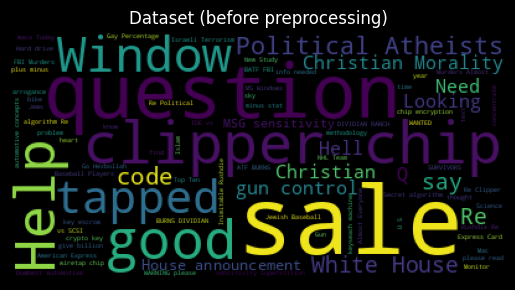

In [12]:
# before preprocessing

cloud = get_word_cloud(" ".join(texts))
plt.title("Dataset (before preprocessing)")
plt.axis("off")
plt.imshow(cloud)

In [ ]:
fig, _axs = plt.subplots(nrows=10, ncols=2, figsize=(10, 20))
fig.subplots_adjust(hspace=0.3)
axs = _axs.flatten()

for _ in range(20):
    axs[_].imshow(get_word_cloud(" ".join(get_from(_))))
    axs[_].set_title(f"Label: {_}")
    axs[_].axis("off")
fig.tight_layout()
plt.show()

## Preprocessing

In [16]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(texts)

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [17]:
print(embeddings.shape)
print(embeddings[0][0:20])

(59545, 384)
[-0.10949051  0.01752549  0.06833326 -0.05048883  0.01307428 -0.01668738
 -0.02064353  0.03873771 -0.03209915  0.016407    0.10264192  0.01111445
  0.07978283 -0.01114773 -0.0478215   0.01050703  0.01809982 -0.02259757
  0.0869754   0.01350243]


In [18]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2 ** 6)  #64
features = pca.fit_transform(embeddings)

In [19]:
print(features.shape)

(59545, 64)


In [20]:
test_features = features[0:10000]
print(test_features.shape)
print(test_features[9])

(10000, 64)
[-0.03578577 -0.03294902 -0.21359688  0.06858786  0.09796298  0.05993768
  0.15945187  0.24713708 -0.17938201 -0.11295573  0.28994986 -0.08548285
 -0.09517093 -0.10903879 -0.01816635  0.06956226  0.24568808  0.04191609
  0.09513362 -0.06502038  0.01595016  0.09525532 -0.06524393 -0.06739604
  0.04817086 -0.03976478  0.07843105 -0.08185127 -0.04945366 -0.00267249
  0.09294061 -0.09974393  0.01911402 -0.13573761 -0.01880888  0.07176825
  0.11395002  0.07375393  0.04550574  0.13610378 -0.0791463   0.0825316
  0.01053157  0.03884076 -0.01577866 -0.06864683 -0.05302685 -0.00159415
 -0.13450414 -0.04096259  0.14991216 -0.05404397 -0.03790912  0.0268942
  0.04480321  0.08370482 -0.10620531  0.03844597 -0.10670166  0.06824769
 -0.07486171 -0.00416078  0.02451568  0.0326033 ]


In [22]:
from src.DBScan import DBScan

scanner =  DBScan(radius=0.6, min_dense=10)
clusters = scanner.make_clusters(features)

In [23]:
import numpy as np
print("Number of clusters produced: ", np.unique(clusters).size)
print(len(np.where(clusters==0)))

Number of clusters produced:  611
1


### Using the DBScan elbow method

In [ ]:
import matplotlib.pyplot as plt

# Don't be crazy running this, i ran it for 70 min and it did not end hahah
# Just for show

k_nearest_neigbours = 10
all_distances = []

for point in features:
    distances = []
    for other_point in features:
        if np.array_equal(point, other_point):
            continue
        distance = np.linalg.norm(point - other_point)
        distances.append(distance)
    distances.sort()
    all_distances.append(distances[k_nearest_neigbours - 1])  

sorted_distances = sorted(all_distances)
k_distance_plot = plt.plot(sorted_distances)

plt.xlabel("Points sorted by distance to their 10 nearest neighboors")
plt.ylabel("Distance to nearest neighboor")
plt.title("K-distance Plot")

plt.show()


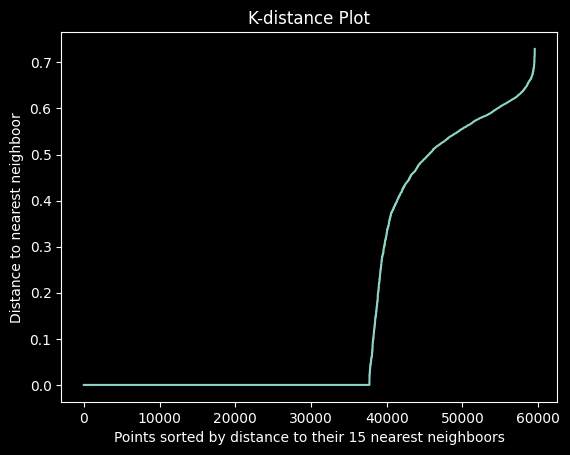

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

k_nearest_neigbours = 10 

k_nearest_neigbours = NearestNeighbors(n_neighbors=k_nearest_neigbours + 1)  
k_nearest_neigbours.fit(features)

distances, indices = k_nearest_neigbours.kneighbors(features)

distances = distances[:, -1]            
distances_sorted = np.sort(distances)

plt.plot(distances_sorted)

plt.xlabel("Points sorted by distance to their 15 nearest neighboors")
plt.ylabel("Distance to nearest neighboor")
plt.title("K-distance Plot")

plt.show()